In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import seaborn as sns; sns.set()
import os
import sklearn

In [3]:
datos  = pd.read_csv(os.path.join('Datos','Transformados', 'df_transformado.csv'))
datos.sample()

,asset,asset_type,brand,segment,checkin_time,checkout_time,booking_time,adult_count,child_count,origin,...,rangos_niños,rango_de_numero_niños,cancelled_imp,dif_can_in,dif_checkin_cancelacion,dif_can_res,dif_fecha_cancelacion_booking,dif_ent_res,dif_reserva_entrada,duracion_reserva
6024,Líbere Vitoria,aparthotel,libere,Leisure Individual,2022-03-12 14:00:00+00:00,2022-03-13 09:59:08+00:00,2022-03-09 12:07:15.631000+00:00,3,0,channel_manager,...,sin niños,sin niños,2000-01-01 00:00:00+00:00,0,0,0,0,4,4,1


In [4]:
datos.corr()['cancellation'].sort_values(ascending = False)

/tmp/ipykernel_9032/2658540219.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  datos.corr()['cancellation'].sort_values(ascending = False)


cancellation                     1.000000
age_nan                          0.832600
dif_can_in                       0.456009
dif_checkin_cancelacion          0.456009
dif_fecha_cancelacion_booking    0.407406
dif_can_res                      0.407406
dif_reserva_entrada              0.211567
dif_ent_res                      0.211567
reservation_nights_net_value     0.133097
reservation_net_value            0.126822
adult_count                      0.039450
total_personas                   0.037190
duracion_reserva                 0.034093
child_count                      0.003336
age                             -0.005659
extras                          -0.009798
extras_net_value                -0.009798
recurrence                      -0.069603
product_count                   -0.073714
Name: cancellation, dtype: float64

## Clustering

### PCA

In [5]:
from sklearn.decomposition import PCA
import pandas as pd
col_names = ['adult_count', 'child_count', 'reservation_net_value', 'total_personas', 'age', 'recurrence', 'dif_can_in', 'dif_can_res', 'dif_ent_res', 'duracion_reserva']
modelado = datos[col_names]
x = modelado.values[:, :]

reduced_data = PCA(n_components=3).fit_transform(x)
reduced_data

array([[-191.00268349,  -13.17774784,    1.42639323],
       [-223.82230935,  -14.46473044,   -2.82549585],
       [ -88.12201982,  -15.93846183,    0.92053469],
       ...,
       [ 131.98982629,  -16.76283729,    2.20590589],
       [-191.76941649,  -13.79349041,   -0.84759573],
       [-195.95092053,  -14.68744219,   -0.94810198]])

### MeanShift

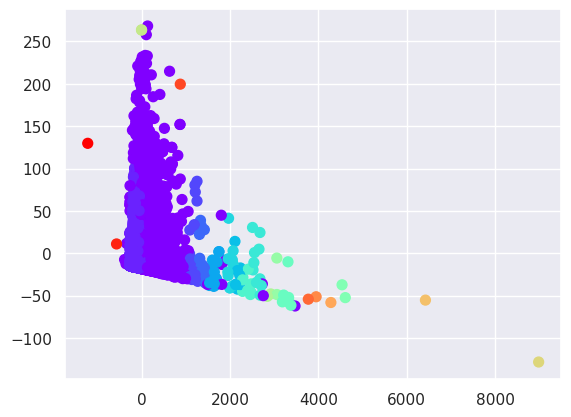

In [6]:
from sklearn.cluster import MeanShift
y_clusters_MS = MeanShift(bandwidth=125,cluster_all=False).fit_predict(reduced_data)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=y_clusters_MS, s=50, cmap='rainbow');

In [7]:
clusters = pd.concat([modelado,pd.DataFrame(y_clusters_MS)], axis = 1).rename(columns = {0:'cluster_meanshift'})
clusters.loc[clusters['cluster_meanshift']>=1, 'cluster_meanshift'] = 1
clusters.groupby('cluster_meanshift').size()

cluster_meanshift
-1    3667
 0    6757
 1     158
dtype: int64

In [8]:
resultados = pd.DataFrame()
resultados['Tipo de Modelo'] = ['MeanShift']
resultados['Numero de grupos'] = [3]
resultados['Grupos'] = [clusters['cluster_meanshift'].unique()]
resultados['Tamaño de grupos'] = [[clusters.groupby('cluster_meanshift').size()]]
resultados['Silhouette Coefficient'] = sklearn.metrics.silhouette_score(reduced_data, y_clusters_MS)

### KMeans

For n_clusters = 2 The average silhouette_score is : 0.8046837017334367
For n_clusters = 3 The average silhouette_score is : 0.6867169751604564
For n_clusters = 4 The average silhouette_score is : 0.6334702708636136
For n_clusters = 5 The average silhouette_score is : 0.6169036580835099
For n_clusters = 6 The average silhouette_score is : 0.5722372550911248


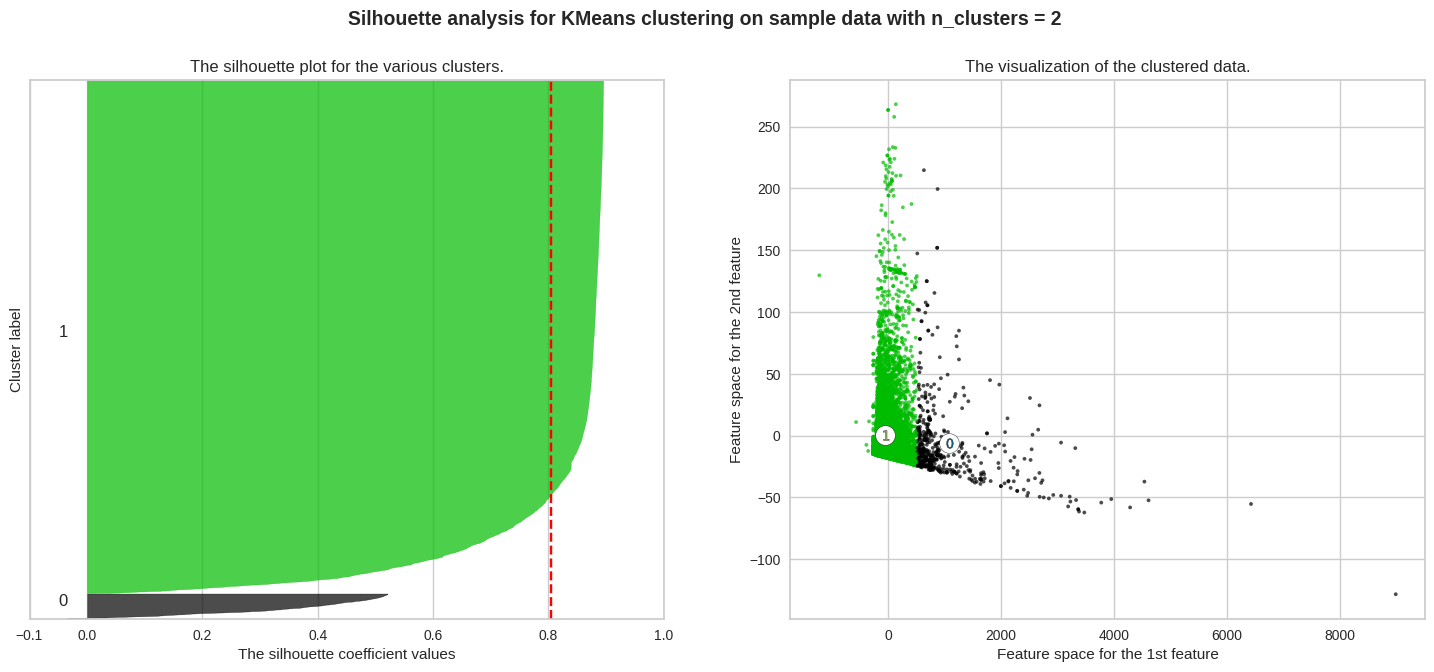

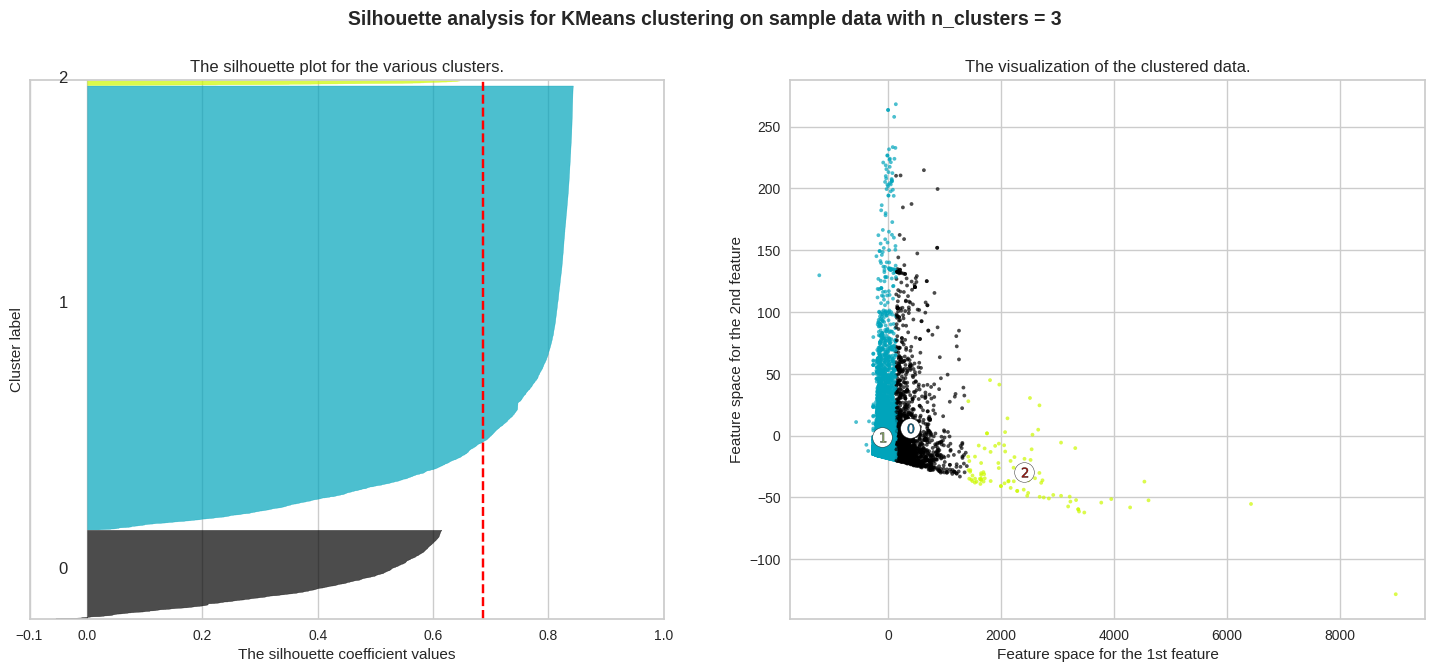

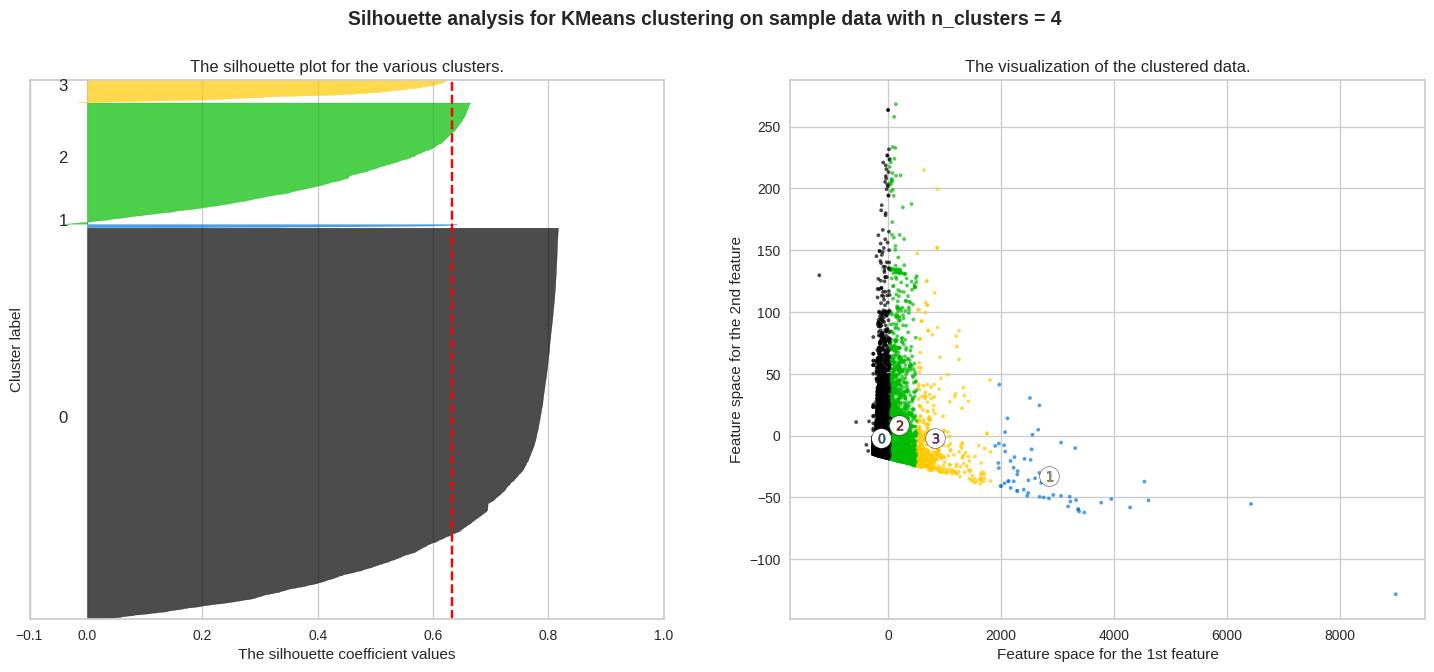

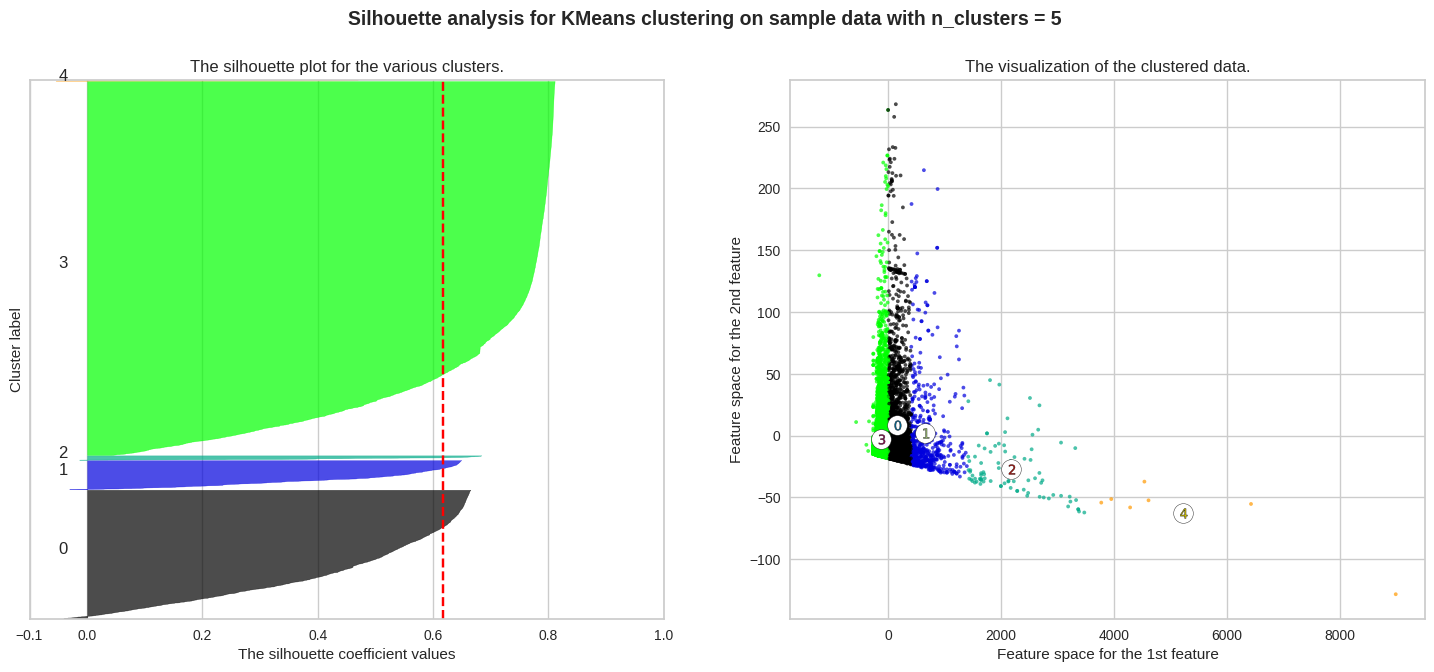

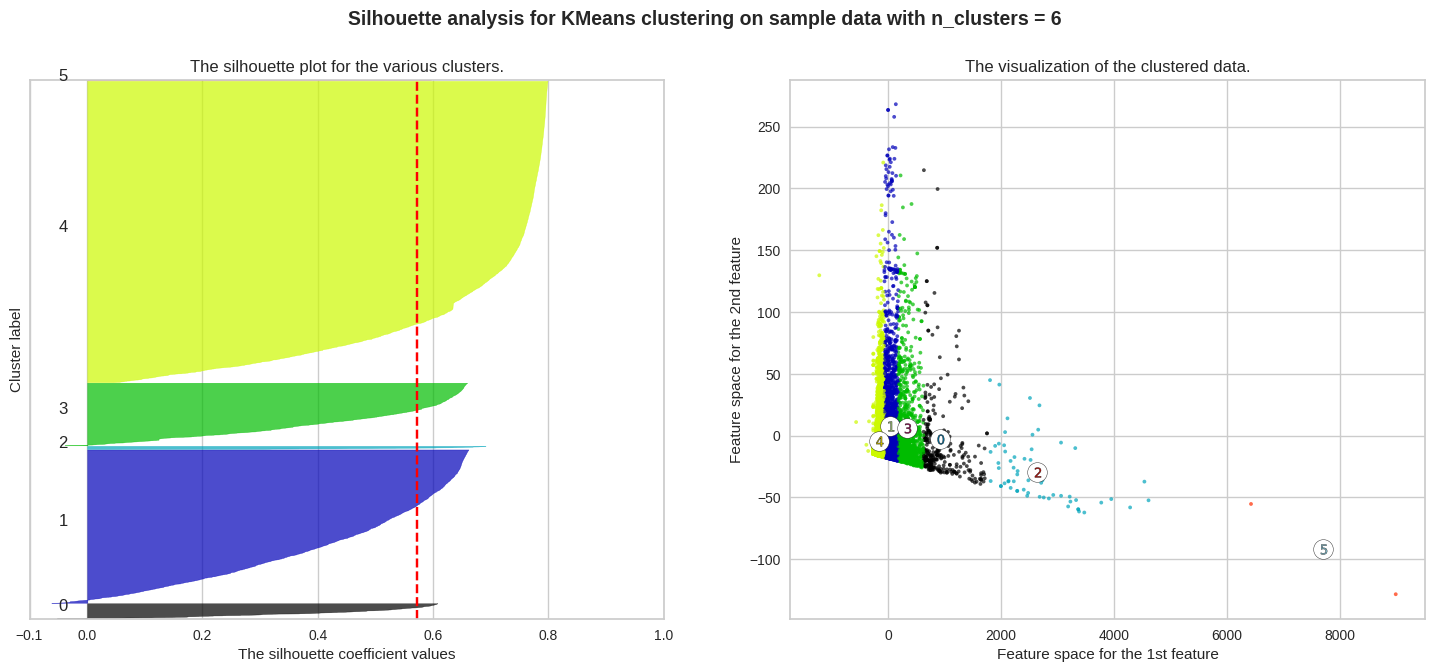

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import pandas as pd

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(reduced_data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(reduced_data)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(reduced_data, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(reduced_data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

### Nos quedamos con k=4

Text(0, 0.5, 'Feature space for the 2nd feature')

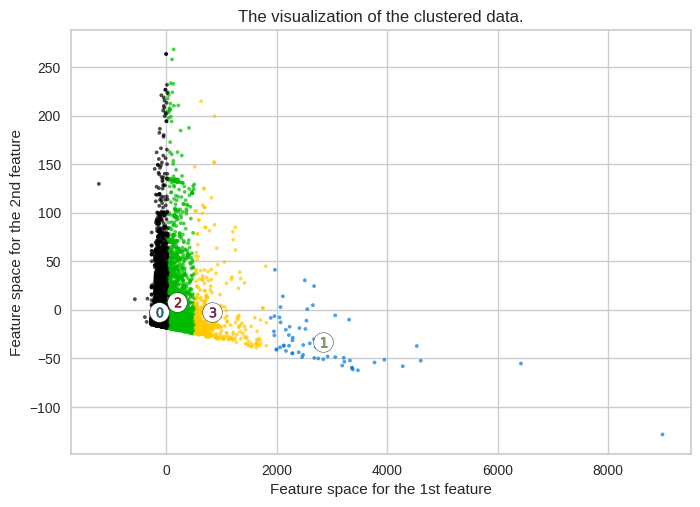

In [10]:
modelo = KMeans(n_clusters=4, random_state=10)
y_clusters_k = modelo.fit_predict(reduced_data)
colors = cm.nipy_spectral(y_clusters_k.astype(float) / 4)
fig, ax2 = plt.subplots()
ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
centers = modelo.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')
for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

In [11]:
clusters = pd.concat([clusters,pd.DataFrame(y_clusters_k)], axis = 1).rename(columns = {0:'cluster_kmeans_k=4'})

In [12]:
nueva_fila = {
    'Tipo de Modelo' : 'KMeans',
    'Numero de grupos' : 4,
    'Grupos' : clusters['cluster_kmeans_k=4'].unique(), 
    'Tamaño de grupos' : [clusters.groupby('cluster_kmeans_k=4').size()],
    'Silhouette Coefficient' : sklearn.metrics.silhouette_score(reduced_data, y_clusters_k)
}
resultados = resultados.append(nueva_fila, ignore_index=True)
resultados

/tmp/ipykernel_9032/3367229003.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados = resultados.append(nueva_fila, ignore_index=True)


,Tipo de Modelo,Numero de grupos,Grupos,Tamaño de grupos,Silhouette Coefficient
0,MeanShift,3,"[0, -1, 1]","[[3667, 6757, 158]]",0.464202
1,KMeans,4,"[0, 2, 3, 1]","[[7703, 60, 2390, 429]]",0.633470


## Hierarchical

For n_clusters = 2 The average silhouette_score is : 0.9646195439065562
For n_clusters = 3 The average silhouette_score is : 0.9072621053690194
For n_clusters = 4 The average silhouette_score is : 0.688843669398073
For n_clusters = 5 The average silhouette_score is : 0.6886336445525438
For n_clusters = 6 The average silhouette_score is : 0.6878985004761864


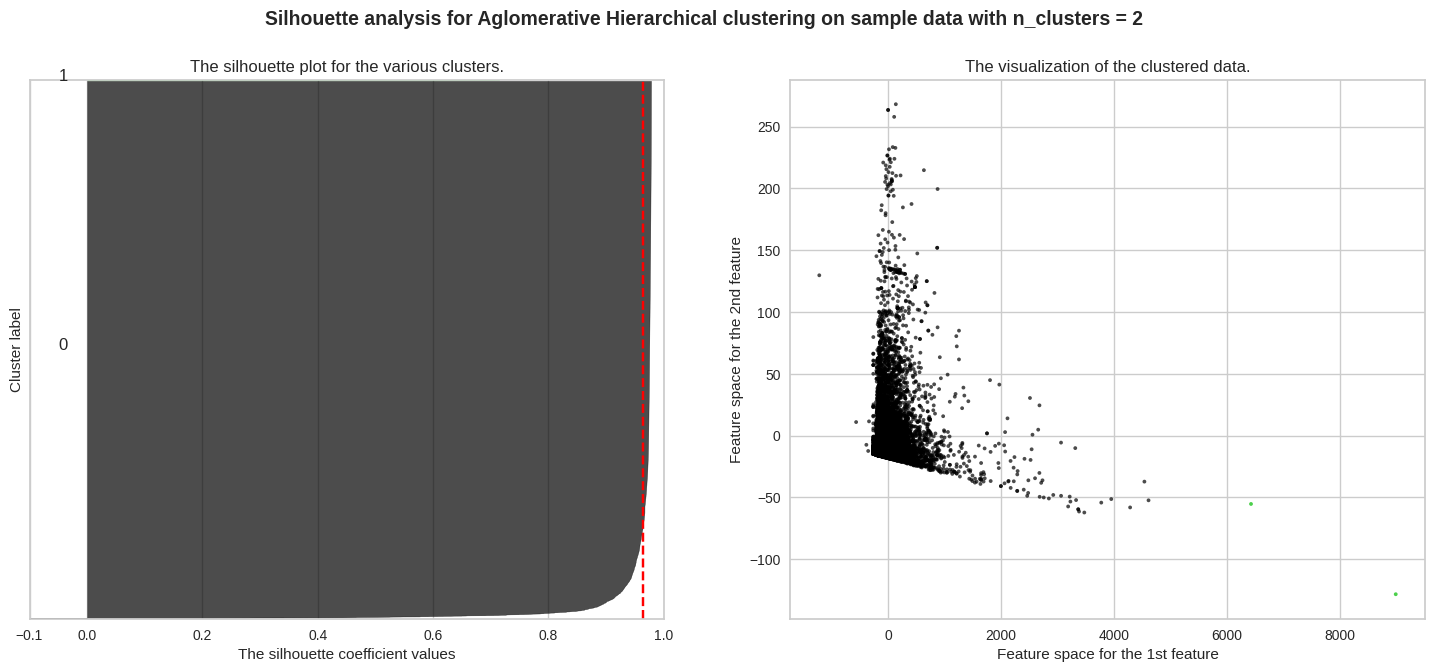

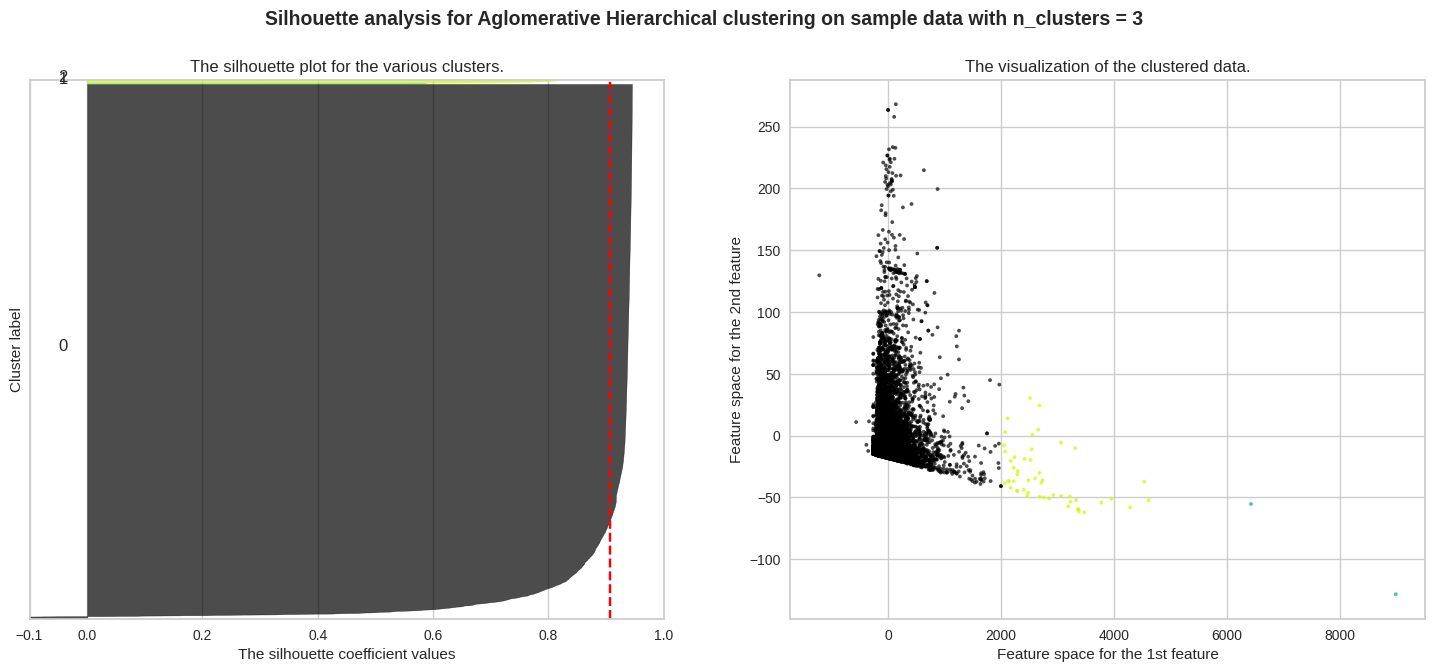

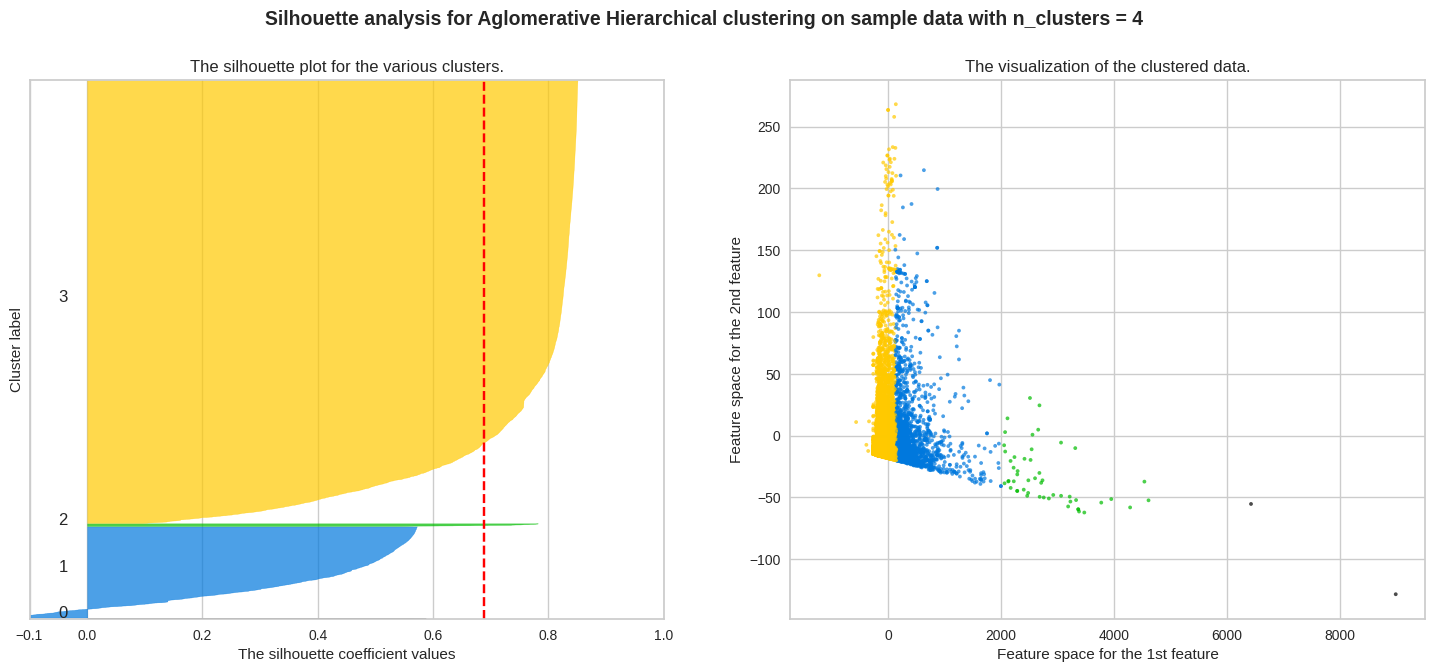

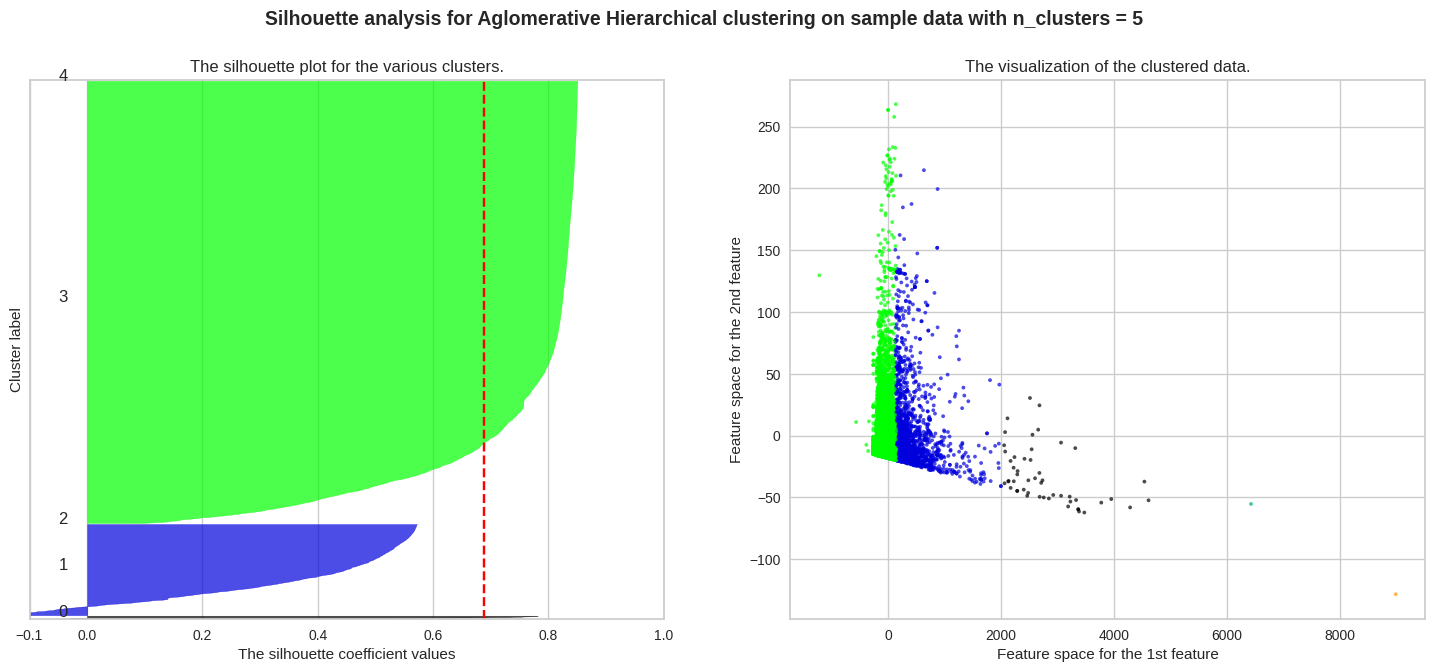

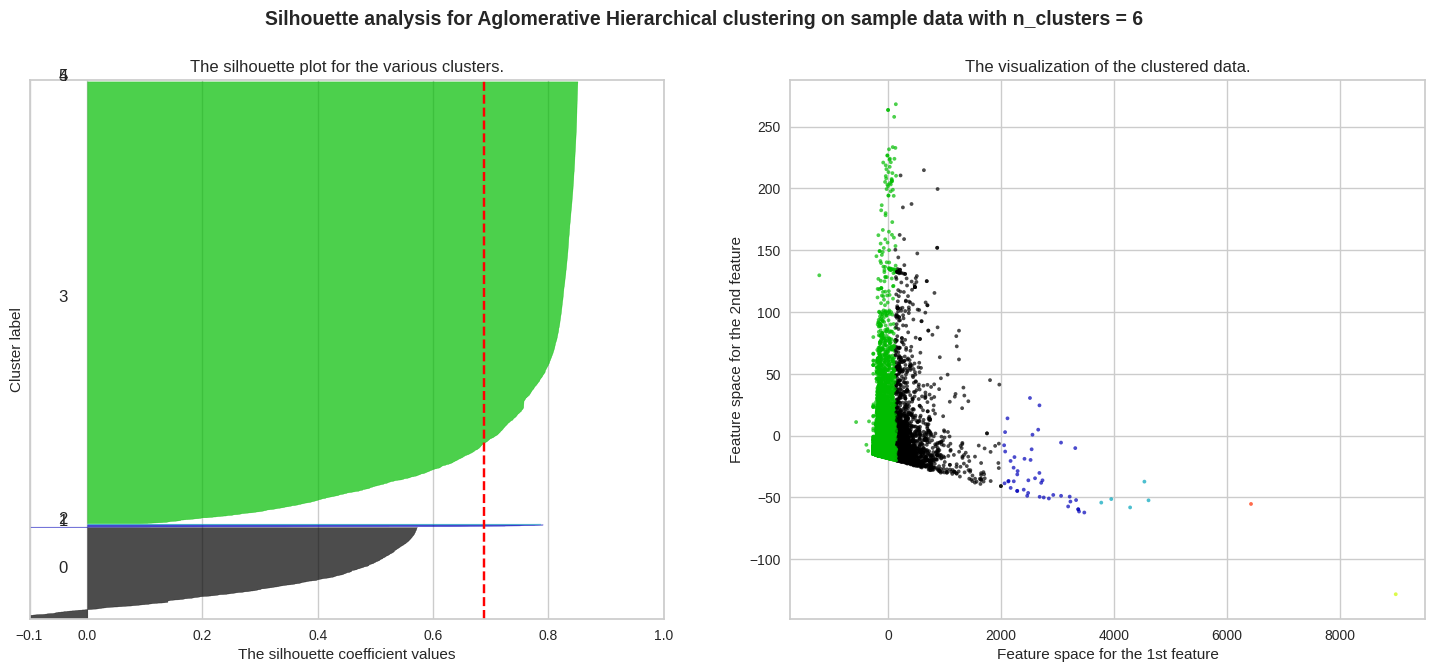

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(reduced_data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='complete')
    cluster_labels=clusterer.fit_predict(reduced_data)
  

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(reduced_data, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(reduced_data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')



    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for Aglomerative Hierarchical clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

### Hierarchical con k = 4

Text(0, 0.5, 'Feature space for the 2nd feature')

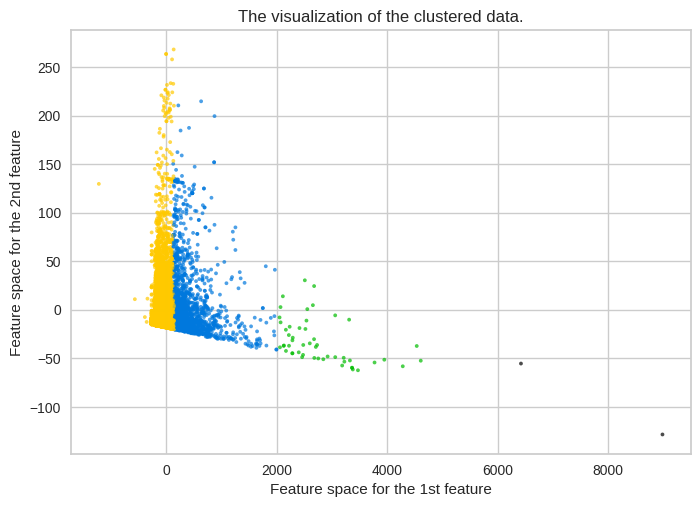

In [14]:
modelo = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')
y_clusters_h = modelo.fit_predict(reduced_data)
colors = cm.nipy_spectral(y_clusters_h.astype(float) / 4)
fig, ax2 = plt.subplots()
ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

In [15]:
clusters = pd.concat([clusters,pd.DataFrame(y_clusters_h)], axis = 1).rename(columns = {0:'cluster_hierarchical'})

In [16]:
nueva_fila = {
    'Tipo de Modelo' : 'Hierarchical',
    'Numero de grupos' : 4,
    'Grupos' : clusters['cluster_hierarchical'].unique(), 
    'Tamaño de grupos' : [clusters.groupby('cluster_hierarchical').size()],
    'Silhouette Coefficient' : sklearn.metrics.silhouette_score(reduced_data, y_clusters_h)
}
resultados = resultados.append(nueva_fila, ignore_index=True)
resultados

/tmp/ipykernel_9032/3013567855.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados = resultados.append(nueva_fila, ignore_index=True)


,Tipo de Modelo,Numero de grupos,Grupos,Tamaño de grupos,Silhouette Coefficient
0,MeanShift,3,"[0, -1, 1]","[[3667, 6757, 158]]",0.464202
1,KMeans,4,"[0, 2, 3, 1]","[[7703, 60, 2390, 429]]",0.633470
2,Hierarchical,4,"[3, 1, 2, 0]","[[2, 1799, 51, 8730]]",0.688844


## DBSCAN

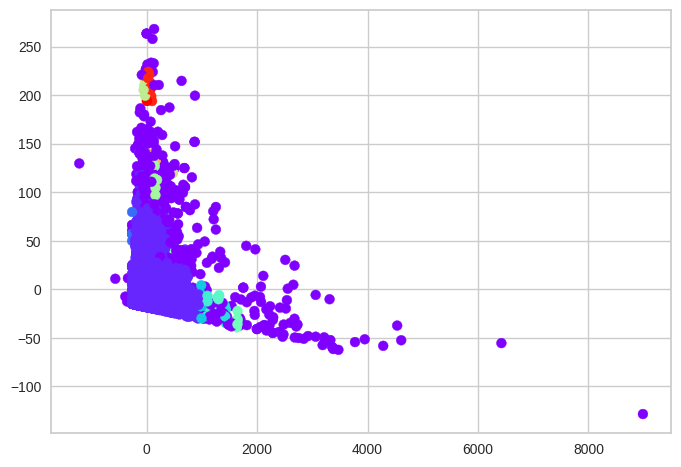

In [17]:
from sklearn.cluster import DBSCAN

y_clusters_DB = DBSCAN(eps=20, min_samples=5).fit_predict(reduced_data)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=y_clusters_DB, s=50, cmap='rainbow');

In [18]:
clusters = pd.concat([clusters,pd.DataFrame(y_clusters_DB)], axis = 1).rename(columns = {0:'cluster_DBSCAN'})

In [19]:
clusters.loc[clusters['cluster_DBSCAN']>=1, 'cluster_DBSCAN'] = 1

In [20]:
nueva_fila = {
    'Tipo de Modelo' : 'DBSCAN',
    'Numero de grupos' : len(clusters['cluster_DBSCAN'].unique()),
    'Grupos' : clusters['cluster_DBSCAN'].unique(), 
    'Tamaño de grupos' : [clusters.groupby('cluster_DBSCAN').size()],
    'Silhouette Coefficient' : sklearn.metrics.silhouette_score(reduced_data, y_clusters_DB)
}
resultados = resultados.append(nueva_fila, ignore_index=True)
resultados

/tmp/ipykernel_9032/2824591449.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados = resultados.append(nueva_fila, ignore_index=True)


,Tipo de Modelo,Numero de grupos,Grupos,Tamaño de grupos,Silhouette Coefficient
0,MeanShift,3,"[0, -1, 1]","[[3667, 6757, 158]]",0.464202
1,KMeans,4,"[0, 2, 3, 1]","[[7703, 60, 2390, 429]]",0.633470
2,Hierarchical,4,"[3, 1, 2, 0]","[[2, 1799, 51, 8730]]",0.688844
3,DBSCAN,3,"[0, -1, 1]","[[386, 10043, 153]]",-0.245712


## Validación

In [21]:
from validclust import ValidClust

vclust = ValidClust(
    k=list(range(2, 7)), 
    methods=['hierarchical', 'kmeans']
)

cvi_vals = vclust.fit_predict(reduced_data)
print(cvi_vals)

                                    2             3             4  \
method       index                                                  
hierarchical silhouette      0.765346      0.740067      0.561038   
             calinski     9916.410281  12076.671820  14277.262178   
             davies          0.626514      0.479182      0.563545   
             dunn            0.000466      0.000597      0.000274   
kmeans       silhouette      0.804684      0.686647      0.633103   
             calinski    10271.119600  15368.530212  17094.368343   
             davies          0.595568      0.527725      0.536348   
             dunn            0.000430      0.000248      0.000256   

                                    5             6  
method       index                                   
hierarchical silhouette      0.563594      0.564029  
             calinski    16543.100947  18817.889716  
             davies          0.594950      0.532938  
             dunn            0.000274  

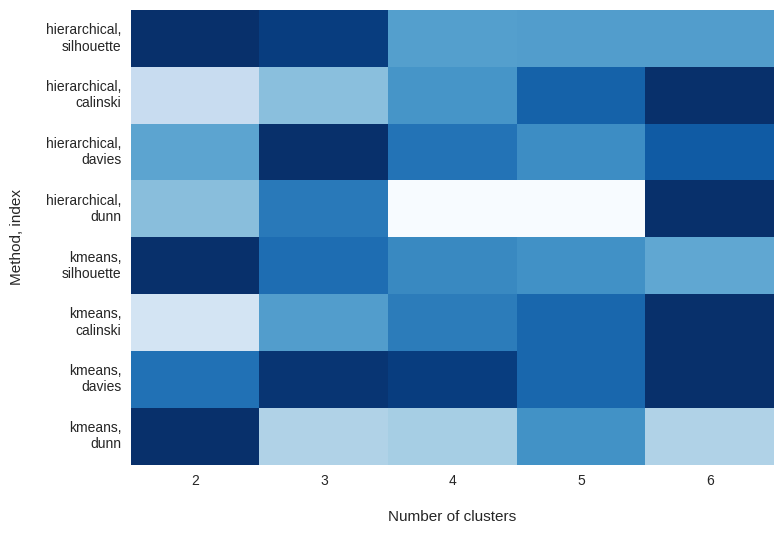

In [22]:
vclust.plot()

## Análisis de los diferentes modelos

In [23]:
resultados

,Tipo de Modelo,Numero de grupos,Grupos,Tamaño de grupos,Silhouette Coefficient
0,MeanShift,3,"[0, -1, 1]","[[3667, 6757, 158]]",0.464202
1,KMeans,4,"[0, 2, 3, 1]","[[7703, 60, 2390, 429]]",0.633470
2,Hierarchical,4,"[3, 1, 2, 0]","[[2, 1799, 51, 8730]]",0.688844
3,DBSCAN,3,"[0, -1, 1]","[[386, 10043, 153]]",-0.245712


In [24]:
resultados.to_csv('./Datos/Transformados/resultados_clusteringG.csv')

### Finalmente, nos vamos a quedar con el de K-Means con k = 4

## Vamos añadir a todos los datos para poder analizar todas las variables

In [25]:
datos_K = pd.concat([datos,pd.DataFrame(y_clusters_k)], axis = 1).rename(columns={0:'cluster'})

In [26]:
medias_cluster_K = datos_K.groupby('cluster').mean()
medias_cluster_K['tamaño_grupo'] = datos_K.groupby('cluster').size()
medias_cluster_K = medias_cluster_K.sort_values('tamaño_grupo', ascending = False)
medias_cluster_K

/tmp/ipykernel_9032/1226502267.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  medias_cluster_K = datos_K.groupby('cluster').mean()


,adult_count,child_count,age,recurrence,product_count,reservation_net_value,reservation_nights_net_value,cancellation,age_nan,extras_net_value,extras,total_personas,dif_can_in,dif_checkin_cancelacion,dif_can_res,dif_fecha_cancelacion_booking,dif_ent_res,dif_reserva_entrada,duracion_reserva,tamaño_grupo
cluster,,,,,,,,,,,,,,,,,,,,
0,2.317668,0.267039,39.181747,1.508373,0.509282,137.162586,132.243157,0.194470,0.144100,4.919429,4.919429,2.584707,2.721927,2.721927,1.890302,1.890302,13.890302,13.890302,1.556536,7703
2,2.626360,0.365272,42.060251,1.141841,1.202510,455.090042,437.314251,0.289540,0.241423,17.775791,17.775791,2.991632,5.889540,5.889540,5.850628,5.850628,27.846862,27.846862,3.541423,2390
3,2.319347,0.312354,41.874126,1.188811,1.834499,1085.153497,1053.243077,0.379953,0.340326,31.910420,31.910420,2.631702,7.673660,7.673660,4.543124,4.543124,24.827506,24.827506,8.930070,429
1,1.600000,0.250000,41.466667,1.650000,5.150000,3108.443667,2960.934333,0.516667,0.416667,147.509333,147.509333,1.850000,8.950000,8.950000,4.116667,4.116667,19.450000,19.450000,31.433333,60


## graficos de clusters

<AxesSubplot: title={'center': 'duracion_reserva'}, xlabel='cluster'>

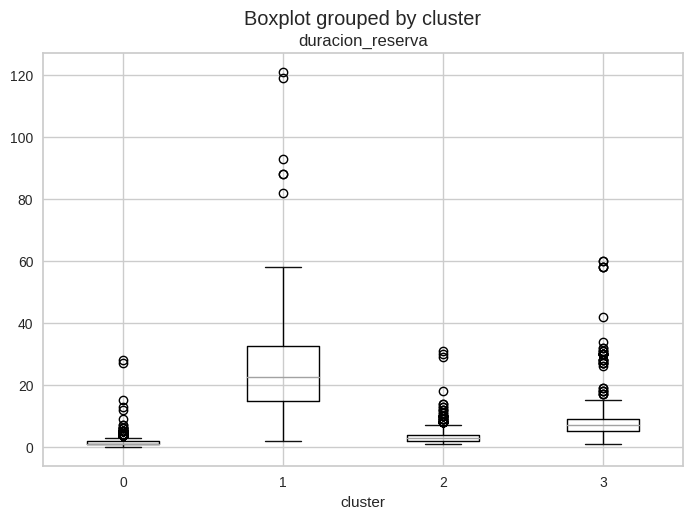

In [56]:
datos_K.boxplot('duracion_reserva', 'cluster')

## Como uno de los grupos es muy grande en tamaño, se ha decidido subdividir en grupos más pequeños

In [27]:
analisis2 = datos_K[datos_K['cluster']==3]

#### PCA

In [28]:
from sklearn.decomposition import PCA
import pandas as pd
col_names = ['adult_count', 'child_count', 'reservation_net_value', 'total_personas', 'age', 'recurrence', 'dif_can_in', 'dif_can_res', 'dif_ent_res', 'duracion_reserva']
modelado2 = analisis2[col_names]
x = modelado2.values[:, :]

reduced_data2 = PCA(n_components=3).fit_transform(x)
reduced_data2

array([[-2.82306432e+02, -2.33298884e+01,  9.71680578e-02],
       [-2.66349029e+02, -1.22022808e+01, -4.13229200e+00],
       [-1.79744794e+02, -4.98348281e+00, -5.27818817e+00],
       ...,
       [ 1.17698744e+02, -1.18214854e+01, -4.05267519e+00],
       [-2.16321907e+02, -6.71451131e+00, -6.86948062e+00],
       [-1.97979018e+02, -1.35906736e+01, -2.26608534e+00]])

### MeanShift

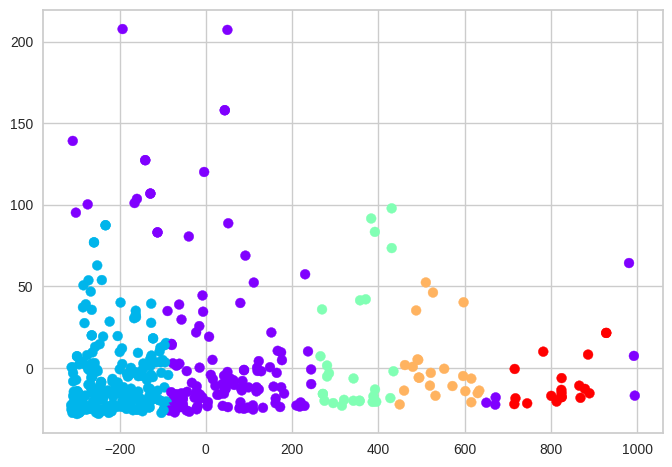

In [29]:
from sklearn.cluster import MeanShift
y_clusters_MS = MeanShift(bandwidth=125,cluster_all=False).fit_predict(reduced_data2)

plt.scatter(reduced_data2[:, 0], reduced_data2[:, 1], c=y_clusters_MS, s=50, cmap='rainbow');

In [30]:
clusters2 = pd.concat([modelado2,pd.DataFrame(y_clusters_MS)], axis = 1).rename(columns = {0:'cluster_meanshift'})
clusters2.groupby('cluster_meanshift').size()

cluster_meanshift
-1.0    142
 0.0    217
 1.0     27
 2.0     23
 3.0     20
dtype: int64

In [47]:
resultados = pd.DataFrame()
resultados['Tipo de Modelo'] = ['MeanShift']
resultados['Numero de grupos'] = [len(clusters2['cluster_meanshift'].unique())]
resultados['Grupos'] = [clusters2['cluster_meanshift'].unique()]
resultados['Tamaño de grupos'] = [[clusters2.groupby('cluster_meanshift').size()]]
resultados['Silhouette Coefficient'] = sklearn.metrics.silhouette_score(reduced_data2, y_clusters_MS)

### KMeans

For n_clusters = 2 The average silhouette_score is : 0.6996223875510279
For n_clusters = 3 The average silhouette_score is : 0.5825749913483799
For n_clusters = 4 The average silhouette_score is : 0.5368428812380293
For n_clusters = 5 The average silhouette_score is : 0.5143562464292509
For n_clusters = 6 The average silhouette_score is : 0.5041641783811159


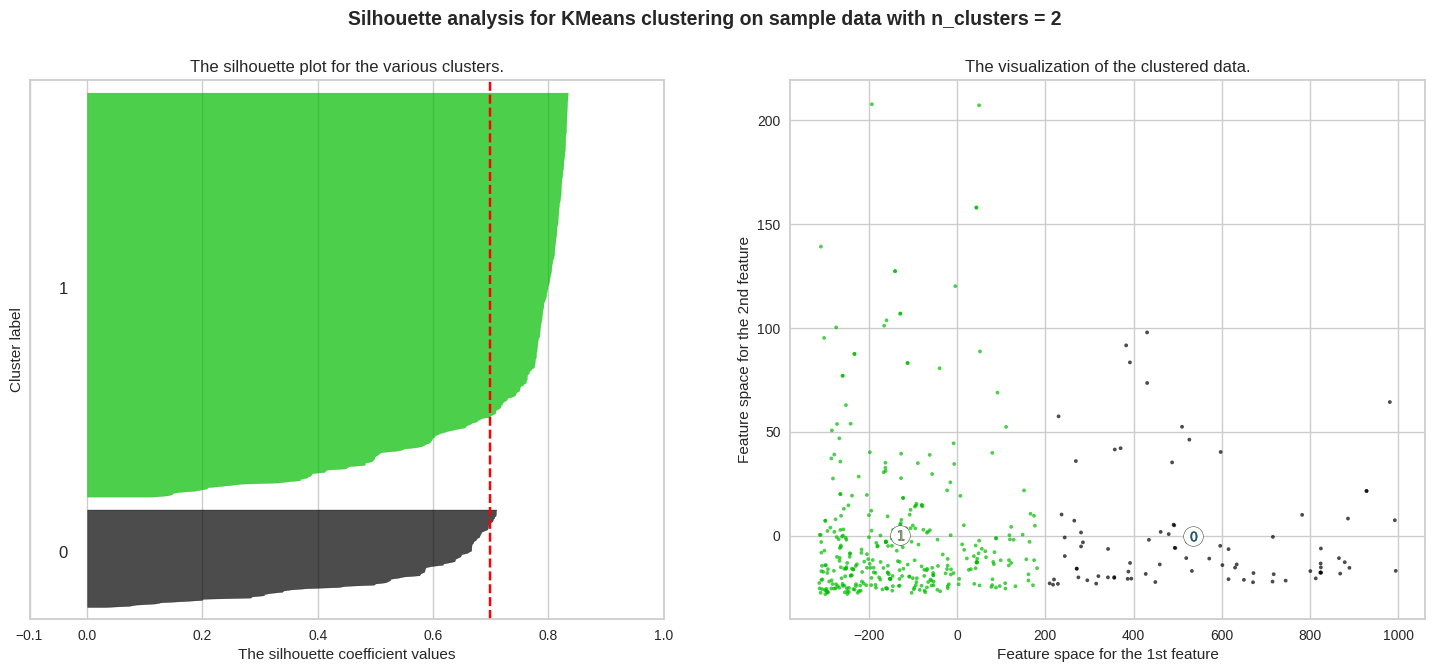

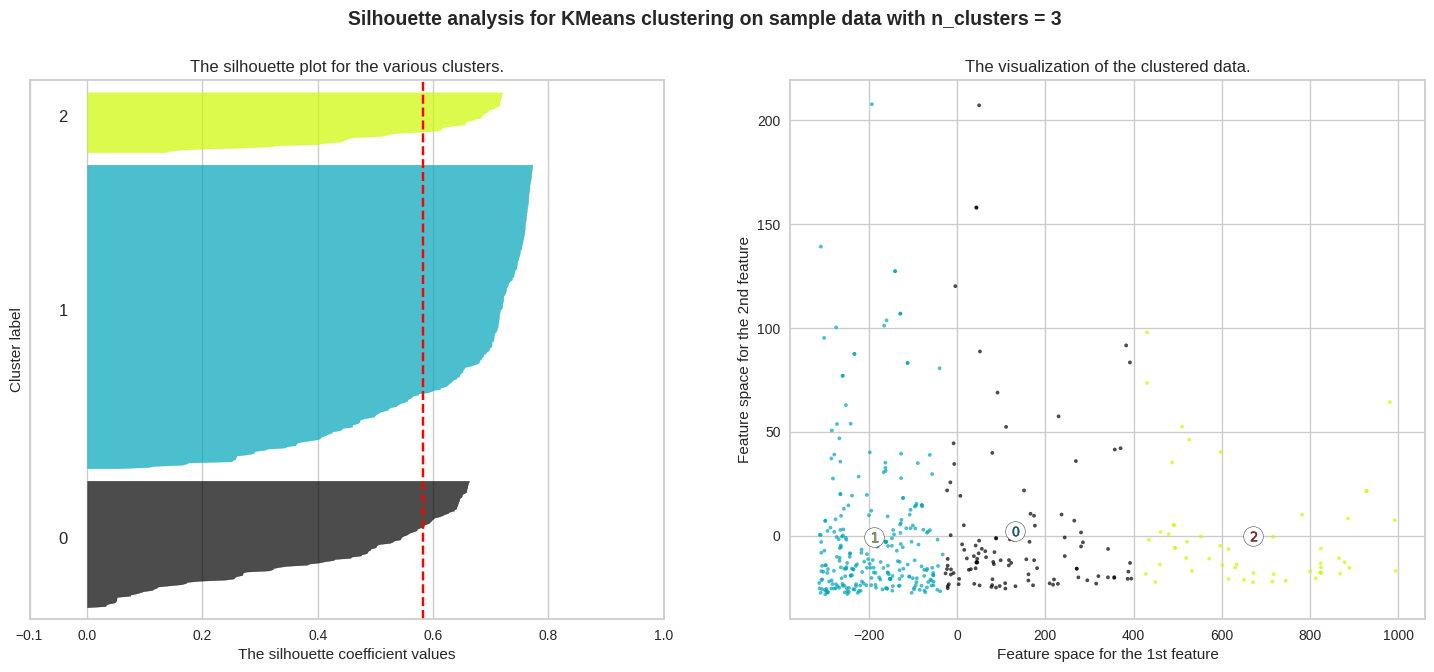

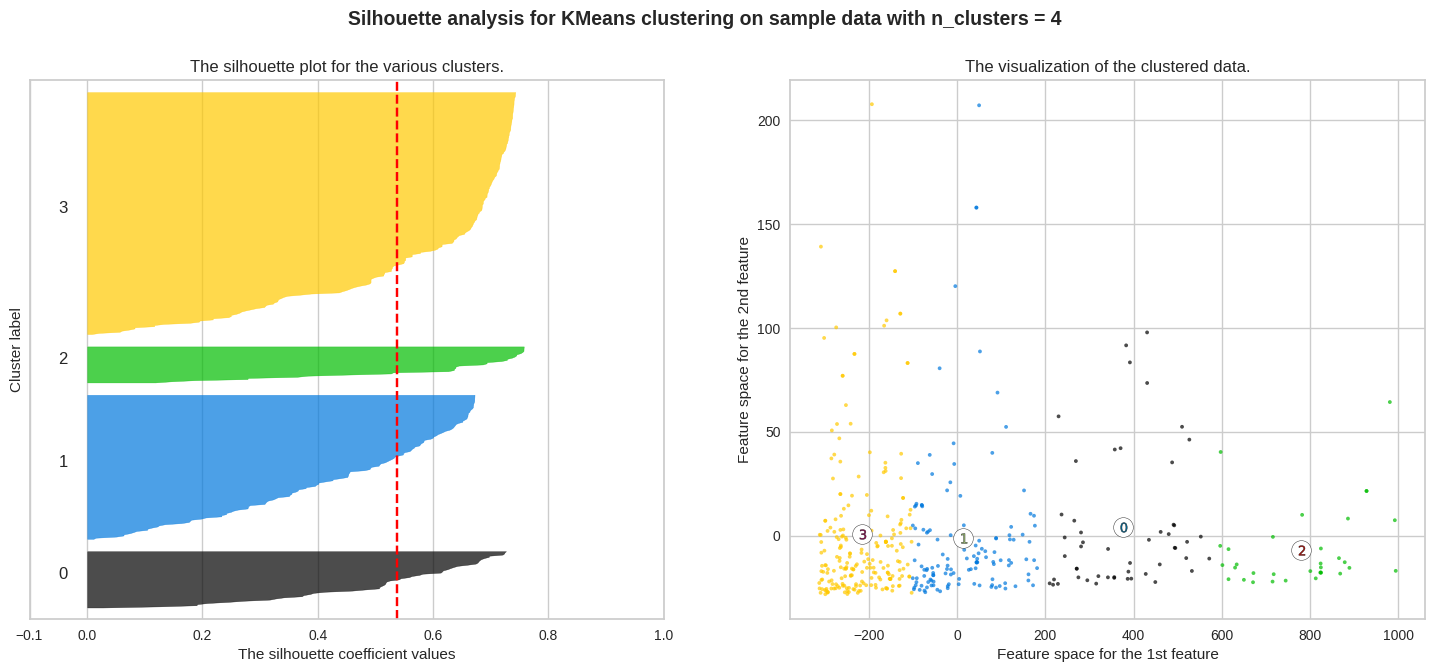

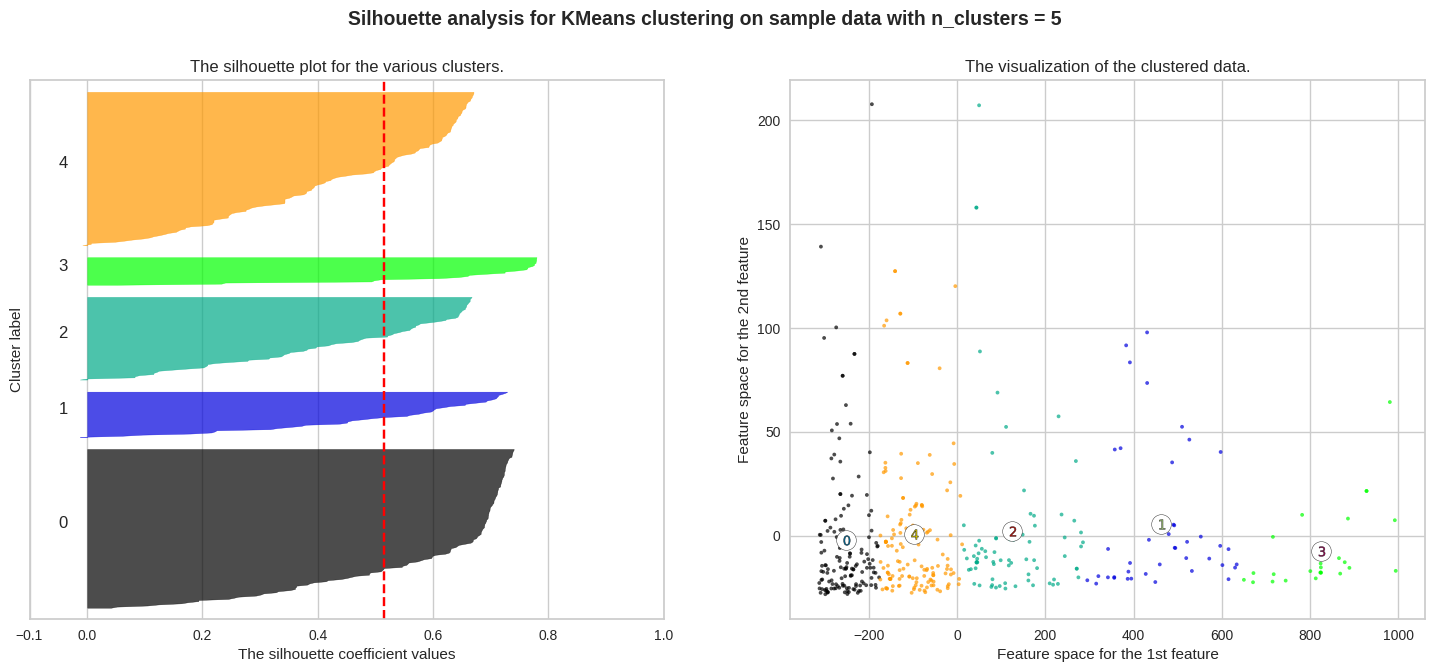

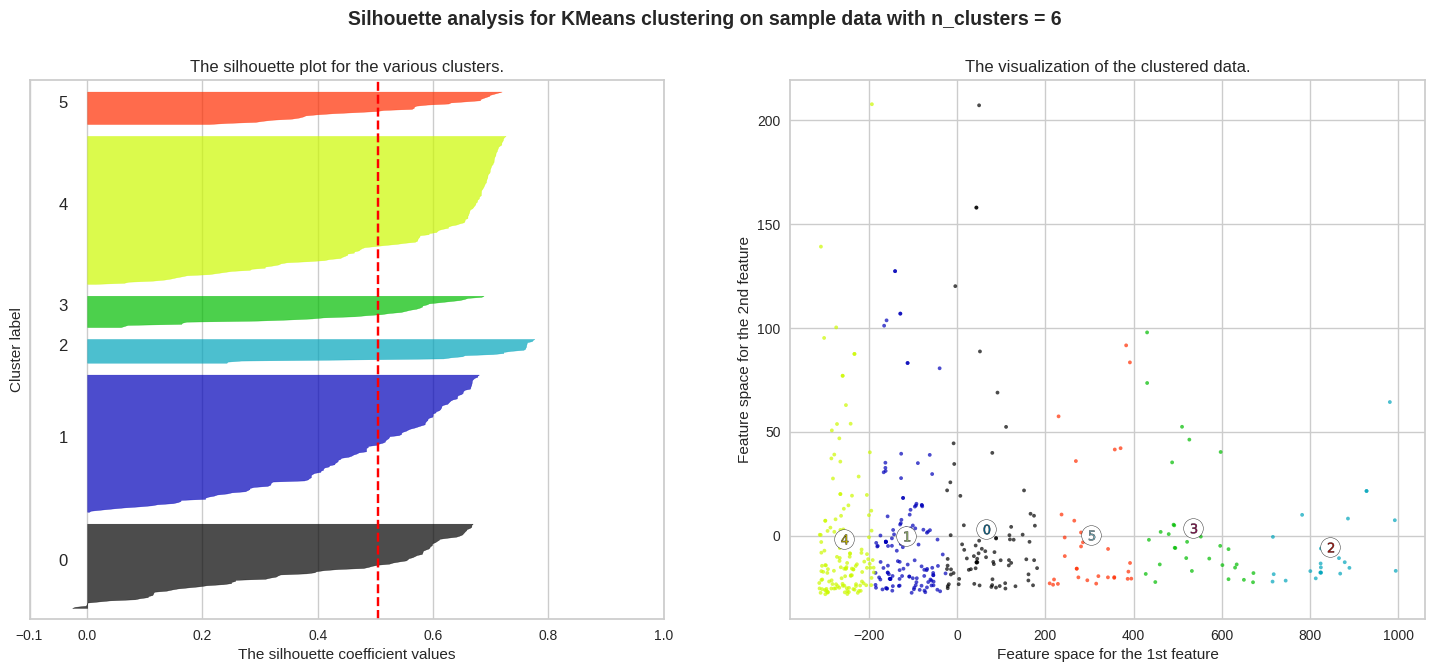

In [32]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import pandas as pd

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(reduced_data2) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(reduced_data2)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(reduced_data2, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(reduced_data2, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(reduced_data2[:, 0], reduced_data2[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

### Nos quedamos con k=4

Text(0, 0.5, 'Feature space for the 2nd feature')

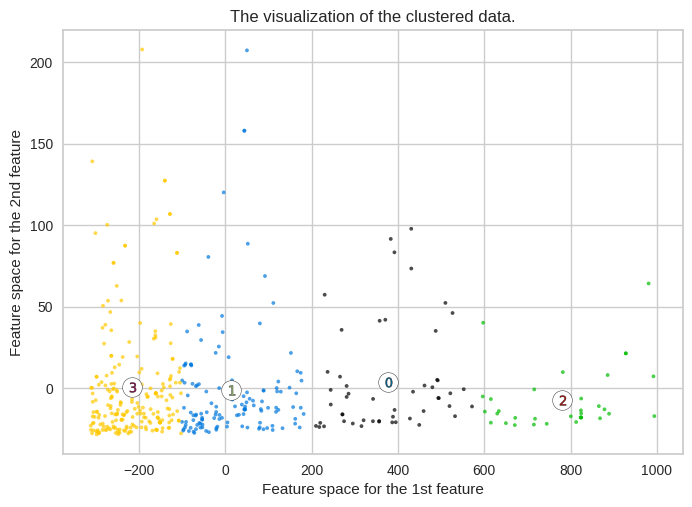

In [33]:
modelo = KMeans(n_clusters=4, random_state=10)
y_clusters_k = modelo.fit_predict(reduced_data2)
colors = cm.nipy_spectral(y_clusters_k.astype(float) / 4)
fig, ax2 = plt.subplots()
ax2.scatter(reduced_data2[:, 0], reduced_data2[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
centers = modelo.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')
for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

In [34]:
clusters2 = pd.concat([clusters2,pd.DataFrame(y_clusters_k)], axis = 1).rename(columns = {0:'cluster_kmeans_k=4'})

In [48]:
nueva_fila = {
    'Tipo de Modelo' : 'KMeans',
    'Numero de grupos' : 4,
    'Grupos' : clusters2['cluster_kmeans_k=4'].unique(), 
    'Tamaño de grupos' : [clusters2.groupby('cluster_kmeans_k=4').size()],
    'Silhouette Coefficient' : sklearn.metrics.silhouette_score(reduced_data2, y_clusters_k)
}
resultados = resultados.append(nueva_fila, ignore_index=True)
resultados

/tmp/ipykernel_9032/2282428793.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados = resultados.append(nueva_fila, ignore_index=True)


,Tipo de Modelo,Numero de grupos,Grupos,Tamaño de grupos,Silhouette Coefficient
0,MeanShift,6,"[0.0, -1.0, 2.0, nan, 1.0, 3.0]","[[142, 217, 27, 23, 20]]",0.460584
1,KMeans,4,"[3.0, 1.0, 0.0, nan, 2.0]","[[51, 129, 33, 216]]",0.536843


## Hierarchical

For n_clusters = 2 The average silhouette_score is : 0.6682872719060353
For n_clusters = 3 The average silhouette_score is : 0.5986379726173789
For n_clusters = 4 The average silhouette_score is : 0.5604319978745486
For n_clusters = 5 The average silhouette_score is : 0.5569393740337258
For n_clusters = 6 The average silhouette_score is : 0.5216576360342926


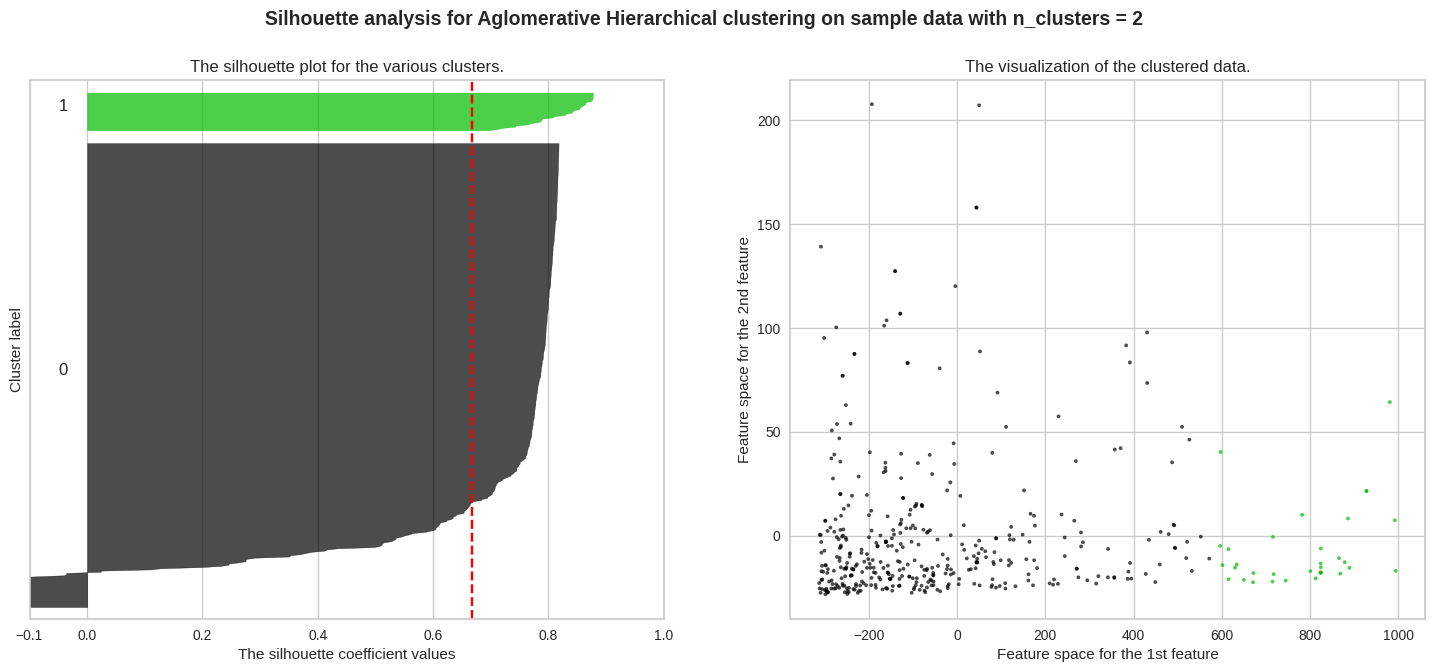

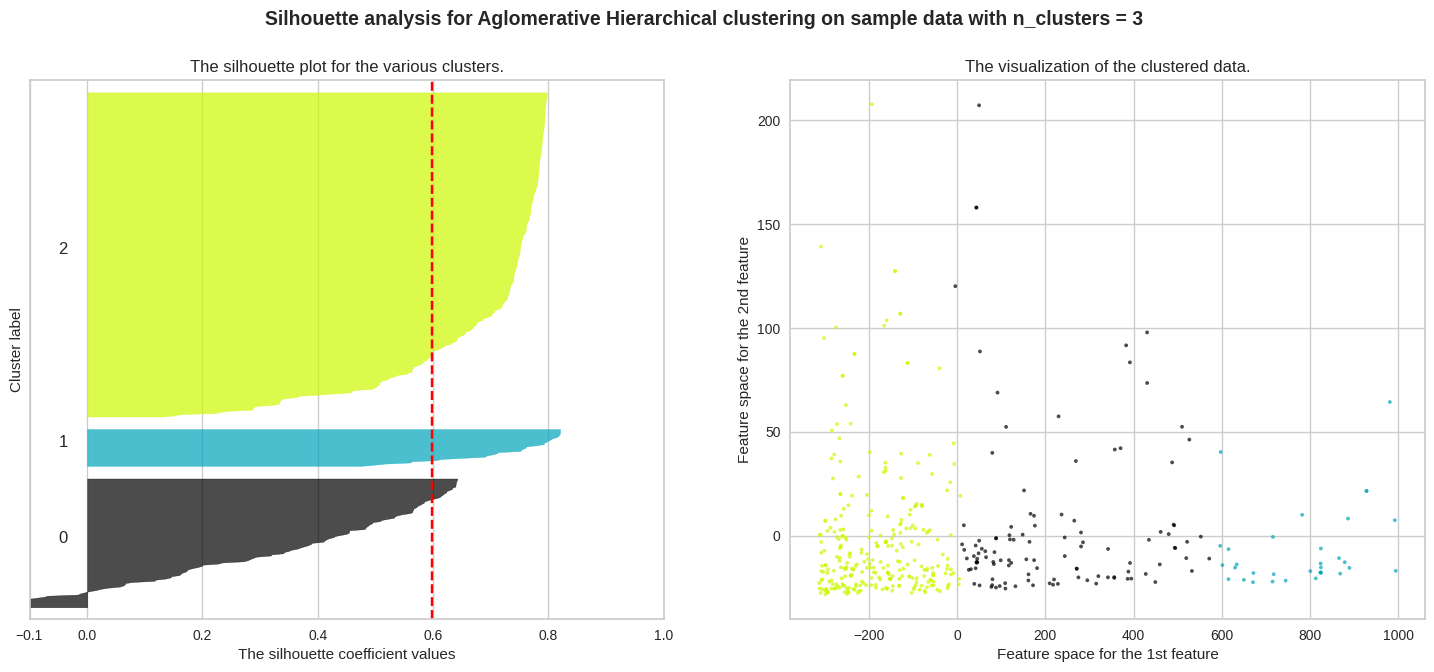

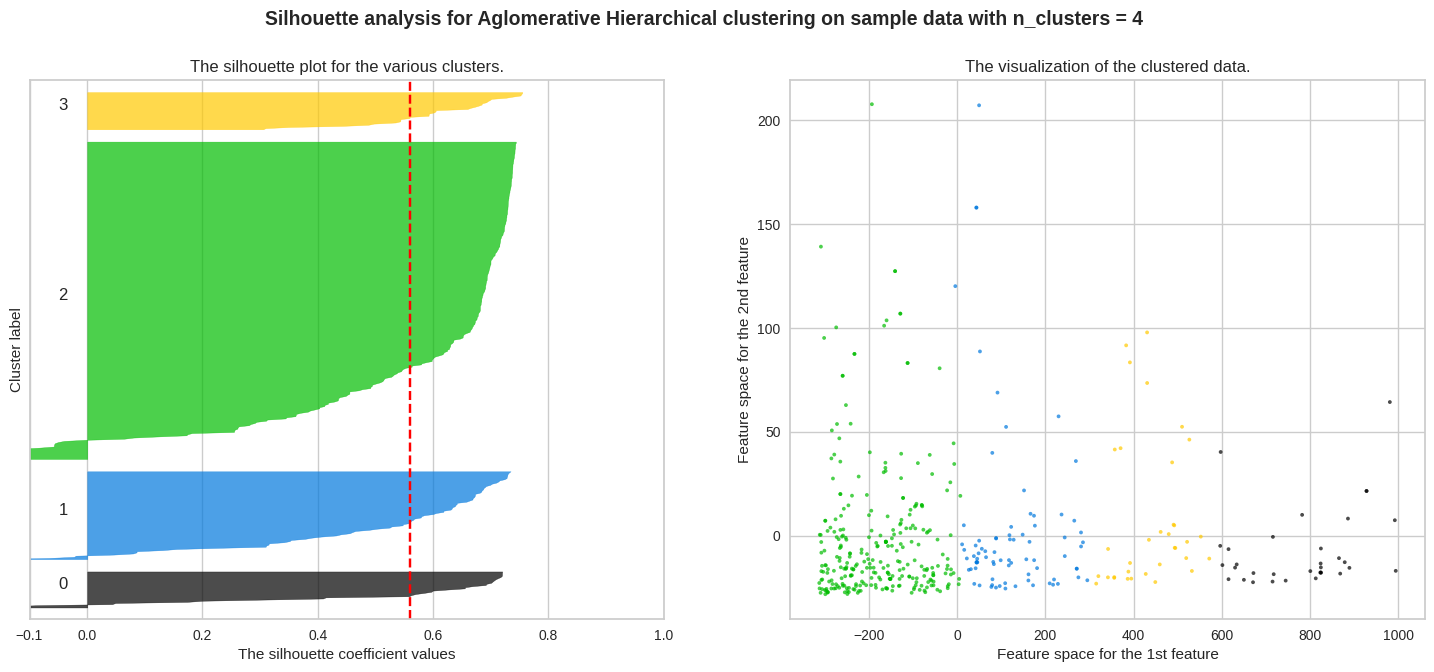

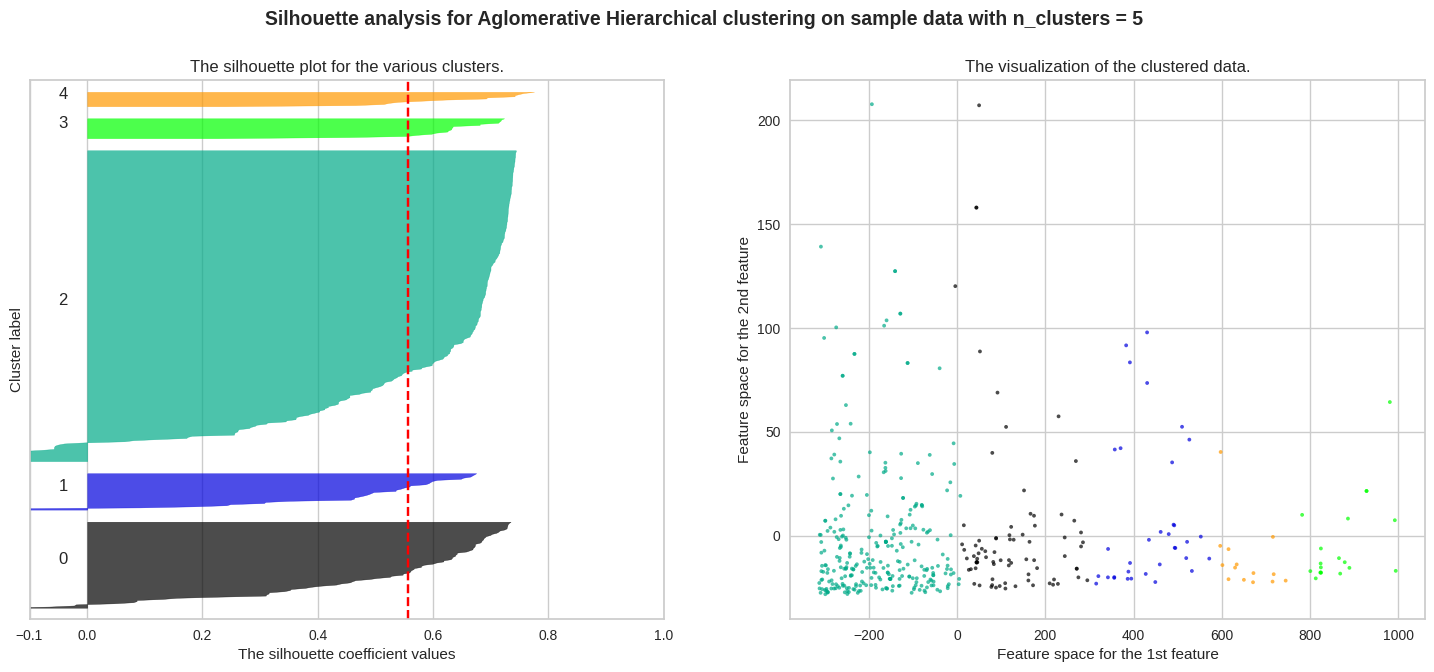

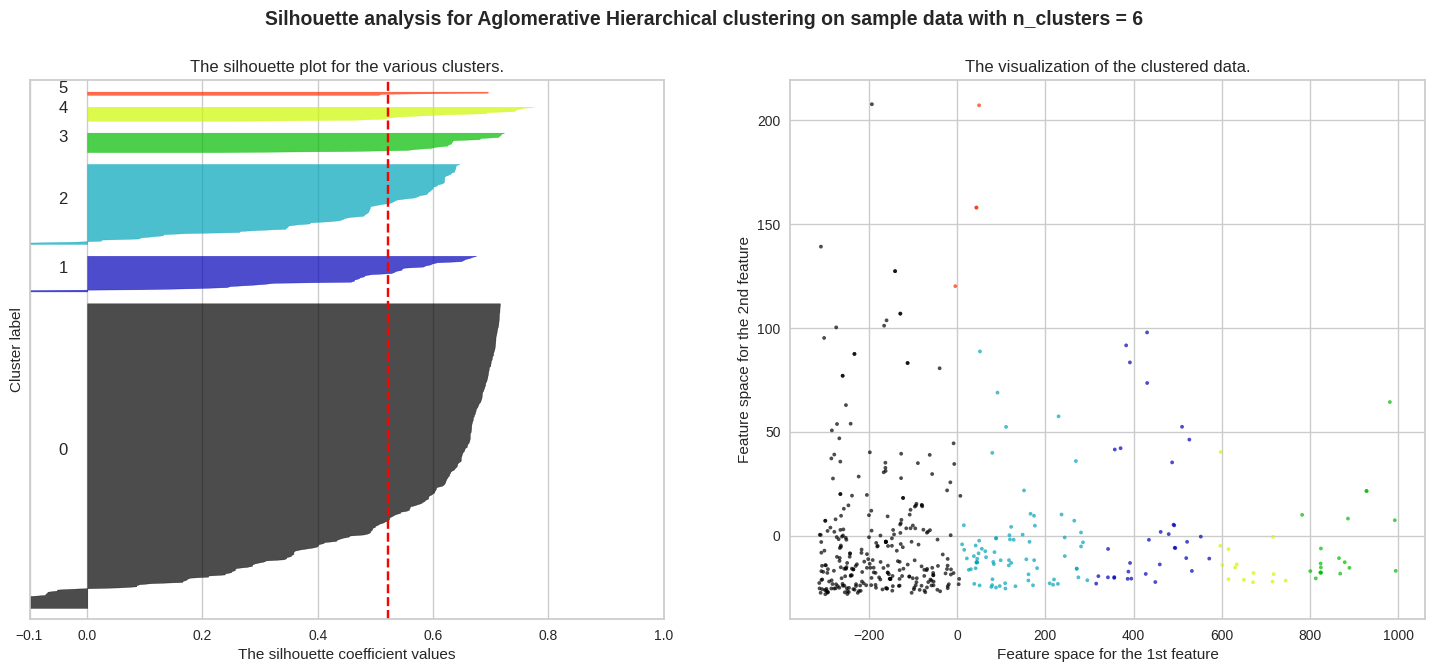

In [36]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(reduced_data2) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='complete')
    cluster_labels=clusterer.fit_predict(reduced_data2)
  

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(reduced_data2, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(reduced_data2, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(reduced_data2[:, 0], reduced_data2[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')



    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for Aglomerative Hierarchical clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

### Hierarchical con k = 4

Text(0, 0.5, 'Feature space for the 2nd feature')

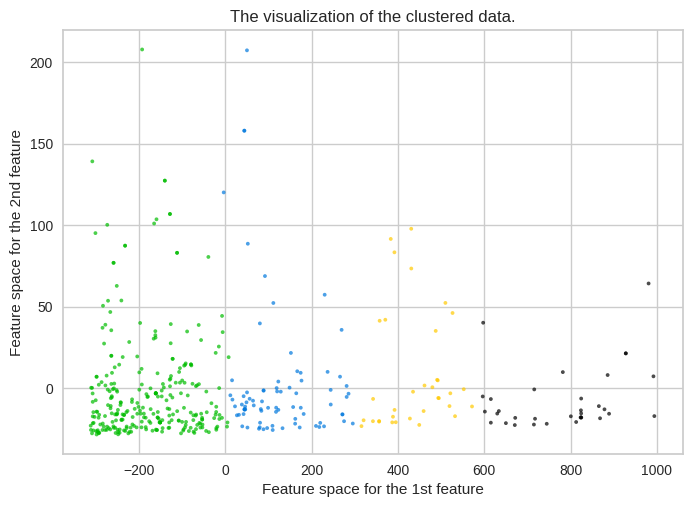

In [37]:
modelo = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')
y_clusters_h = modelo.fit_predict(reduced_data2)
colors = cm.nipy_spectral(y_clusters_h.astype(float) / 4)
fig, ax2 = plt.subplots()
ax2.scatter(reduced_data2[:, 0], reduced_data2[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

In [38]:
clusters2 = pd.concat([clusters2,pd.DataFrame(y_clusters_h)], axis = 1).rename(columns = {0:'cluster_hierarchical'})

In [49]:
nueva_fila = {
    'Tipo de Modelo' : 'Hierarchical',
    'Numero de grupos' : 4,
    'Grupos' : clusters2['cluster_hierarchical'].unique(), 
    'Tamaño de grupos' : [clusters2.groupby('cluster_hierarchical').size()],
    'Silhouette Coefficient' : sklearn.metrics.silhouette_score(reduced_data2, y_clusters_h)
}
resultados = resultados.append(nueva_fila, ignore_index=True)
resultados

/tmp/ipykernel_9032/1725199283.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados = resultados.append(nueva_fila, ignore_index=True)


,Tipo de Modelo,Numero de grupos,Grupos,Tamaño de grupos,Silhouette Coefficient
0,MeanShift,6,"[0.0, -1.0, 2.0, nan, 1.0, 3.0]","[[142, 217, 27, 23, 20]]",0.460584
1,KMeans,4,"[3.0, 1.0, 0.0, nan, 2.0]","[[51, 129, 33, 216]]",0.536843
2,Hierarchical,4,"[2.0, 1.0, 3.0, nan, 0.0]","[[33, 79, 283, 34]]",0.560432


## DBSCAN

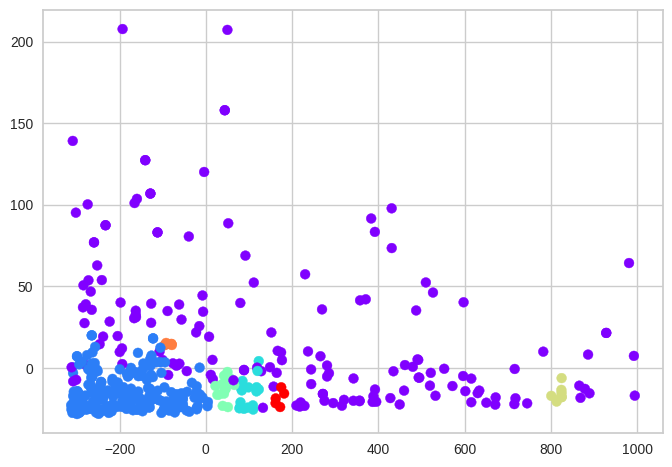

In [40]:
from sklearn.cluster import DBSCAN

y_clusters_DB = DBSCAN(eps=15, min_samples=5).fit_predict(reduced_data2)

plt.scatter(reduced_data2[:, 0], reduced_data2[:, 1], c=y_clusters_DB, s=50, cmap='rainbow');

In [50]:
clusters2 = pd.concat([clusters2,pd.DataFrame(y_clusters_DB)], axis = 1).rename(columns = {0:'cluster_DBSCAN'})

In [51]:
nueva_fila = {
    'Tipo de Modelo' : 'DBSCAN',
    'Numero de grupos' : len(clusters2['cluster_DBSCAN'].unique()),
    'Grupos' : clusters2['cluster_DBSCAN'].unique(), 
    'Tamaño de grupos' : [clusters2.groupby('cluster_DBSCAN').size()],
    'Silhouette Coefficient' : sklearn.metrics.silhouette_score(reduced_data2, y_clusters_DB)
}
resultados = resultados.append(nueva_fila, ignore_index=True)
resultados

AttributeError: 'DataFrame' object has no attribute 'unique'

## Análisis de los diferentes modelos

In [43]:
resultados

,Tipo de Modelo,Numero de grupos,Grupos,Tamaño de grupos,Silhouette Coefficient
0,MeanShift,2,"[0.0, -1.0, 2.0, nan, 1.0, 3.0]","[[142, 217, 27, 23, 20]]",0.460584
1,KMeans,4,"[3.0, 1.0, 0.0, nan, 2.0]","[[51, 129, 33, 216]]",0.536843
2,Hierarchical,4,"[2.0, 1.0, 3.0, nan, 0.0]","[[33, 79, 283, 34]]",0.560432
3,DBSCAN,8,"[0.0, -1.0, nan, 1.0, 4.0, 5.0, 2.0, 3.0]","[[161, 217, 16, 17, 8, 5, 5]]",-0.146404


In [44]:
resultados.to_csv('./Datos/Transformados/resultados_clustering_C3.csv')

### Finalmente, nos vamos a quedar con el de K-Means con k = 4

## Vamos añadir a todos los datos para poder analizar todas las variables

In [45]:
analisis2_c = pd.concat([analisis2,pd.DataFrame(y_clusters_k)], axis = 1).rename(columns={0:'cluster2'})

In [46]:
medias_cluster_K = analisis2_c.groupby('cluster2').mean()
medias_cluster_K['tamaño_grupo'] = analisis2_c.groupby('cluster2').size()
medias_cluster_K = medias_cluster_K.sort_values('tamaño_grupo', ascending = False)
medias_cluster_K

/tmp/ipykernel_9032/1706583444.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  medias_cluster_K = analisis2_c.groupby('cluster2').mean()


,adult_count,child_count,age,recurrence,product_count,reservation_net_value,reservation_nights_net_value,age_nan,extras_net_value,extras,total_personas,dif_can_in,dif_checkin_cancelacion,dif_can_res,dif_fecha_cancelacion_booking,dif_ent_res,dif_reserva_entrada,duracion_reserva,cluster,tamaño_grupo
cluster2,,,,,,,,,,,,,,,,,,,,
3.0,3.0,0.333333,33.333333,1.0,0.666667,795.706667,794.206667,0.333333,1.5,1.5,3.333333,7.666667,7.666667,0.666667,0.666667,18.666667,18.666667,3.333333,3.0,216
1.0,4.0,2.000000,46.000000,1.0,0.000000,818.820000,818.820000,0.000000,0.0,0.0,6.000000,0.000000,0.000000,0.000000,0.000000,17.000000,17.000000,3.000000,3.0,129
0.0,6.0,0.000000,30.000000,1.0,2.000000,905.410000,890.410000,0.000000,15.0,15.0,6.000000,0.000000,0.000000,0.000000,0.000000,24.000000,24.000000,3.000000,3.0,51
2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33
